In [1]:
from urllib.request import urlopen
import json
import re
from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
import datetime
import ast # string to dirc
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

In [2]:
# remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    dataSet = dataSet.drop_duplicates(subset="id")
    # find stats in dataset
    for s in dataSet['stats']:
        # only add when at least 1 active
        sDirc = ast.literal_eval(s)
        if int(sDirc['activeUsers'])>1:
            data = dataSet.loc[dataSet['stats']==s]
            activeDataSet = activeDataSet.append(data)#    
    # remove duplicates
    #activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet

In [3]:
# get wikis/dataset from csv
fullDataSet = pd.read_csv("data/sortedWikiData.csv", sep='\t')



In [4]:
### Filter Data ###
activeDataSet = findActiveWikis(fullDataSet)
len(activeDataSet)

5849

In [5]:
def makeStringToList(string):
    if string == "[]":
        return []
    l = string.replace("['","")
    l = l.replace("']","")
    l = l.replace("_"," ")
    l = l.split("', '")
    return l

In [6]:
### Get Users from user-wikis ###
users = {}
filename = "data/users/user-wikis.txt"
f = open(filename, "r")


for line in f.read().splitlines():
    user = line.split(': ')
    if len(user) == 2:
        if user[0] not in users:
            users[user[0]] = []
        users[user[0]] = list(set(users[user[0]]+makeStringToList(user[1])))
    
    #print(user)

print(len(users))

22241


In [7]:
activeDataSet['name']

0                Radio-TV Broadcast History
2                                    中文電視大典
6                      Greek TV Series Wiki
32                          SM:tv Live Wiki
39                               Oz TV Wiki
69               Renesanční Království Wiki
73                               电影维基_Wikia
129        V: The Visitors Return MUSH Wiki
143                        Blue Bloods Wiki
150                     Wiki Los Super Once
154                Fictionaltvstations Wiki
187                         Blue Peter Wiki
189                          Logopedia Wiki
194                               Iptv Wiki
241         Cardfight!! Vanguard Fanon Wiki
249                        Indie Game Guide
252                    Paper Computer Games
258                  Tony Hawk's Games Wiki
259                          TEW Games Wiki
265                         Game Shows Wiki
274                         LEGO Games Wiki
278                        Armor Games Wiki
287                          Car

In [8]:
# create edges between all wikis which share users
def createEdges(G,userWikis):
    length = len(userWikis)
    
    # Check if it is the last wiki in the list
    if length<=1:
        return G
    
    # Resursive call
    elif length>1:
        wiki = userWikis.pop()
        wiki = wiki.replace("_"," ")
        # Check wiki exsist in dataset
        if wiki in G.nodes():
            wikisNotInDataSet = []

            # Create edges
            for w in userWikis:
                w = w.replace("_"," ")
                if w in G.nodes():
                    if G.has_edge(wiki, w):
                        G[wiki][w]['weight']+=1
                    else:
                        G.add_edge(wiki,w,weight=1)
                else:
                    wikisNotInDataSet.append(w)
            if len(wikisNotInDataSet) > 0:
                length = len(userWikis)
                userWikis = list(set(userWikis) - set(wikisNotInDataSet))
                print(length - len(userWikis))
        return createEdges(G,userWikis)
    else:
        return G

In [9]:
# Make graph
G = nx.Graph()

# add nodes
for wiki in activeDataSet.T.items():
    wiki = wiki[1]
    name = wiki['name']
    if str(name) == "nan":
        print(name)
        continue
    hub = set(activeDataSet['hub'].loc[activeDataSet['name'] ==name].values)
    stats = ast.literal_eval((activeDataSet['stats'].loc[activeDataSet['name'] ==name].values)[0])
    allUsers = stats['users']
    activeUsersStats = stats['activeUsers']
    usersOccurances = 0
    for values in users.values():
        for value in values:
            if value == name:
                usersOccurances+=1
    G.add_node(name, hub=hub, allUsers=allUsers, activeUsers=activeUsersStats, usersOccurances=usersOccurances)

nan


In [10]:
# iterate over all users
for k,v in users.items():
    #print(set(v))
    G = createEdges(G,set(v))

145
27
2
1
1
33
8
2
17
10
1
1
12
4
2
1
197
31
3
4
1
3
1
1
1
4
2
33
182
1
28
2
1
2
5
1
1
2
1
10
2
4
1
2
1
1
2
2
1
3
1
2
1
1
1
1
309
1
1
1
6
1
1
18
1
4
1
1
5
1
1
4
3
1
13
2
1
3
1
2
1
1
3
187
2
1
2
3
6
2
3
1
1
8
1
2
30
3
2
1
1
225
1
2
3
26
3
3
1
12
1
3
7
1
1
1
13
1
1
1
128
5
13
3
4
3
1
1
2
1
1
2
6
1
1
1
10
1
1
277
4
22
1
10
1
5
1
2
1
1
5
2
3
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2


In [11]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [03:26<00:00,  8.78it/s]

BarnesHut Approximation  took  57.15  seconds
Repulsion forces  took  130.65  seconds
Gravitational forces  took  1.78  seconds
Attraction forces  took  2.85  seconds
AdjustSpeedAndApplyForces step  took  7.14  seconds


In [12]:
# Find degrees according to hub
nodes = {}
for i in range(len(G.nodes)):
    n = list(G.nodes)[i]
    if str(n) == "nan":
        #G.remove(n)
        continue
    nodehub = list(G.node[n]['hub'])[0]
    if nodehub not in nodes:
        nodes[nodehub] = []
    nodes[nodehub].append(n)

for k, v in nodes.items():
    print(k, len(v))
len(nodes)

TV 1032
Games 2201
Movies 385
Lifestyle 661
Books 430
Comics 328
Music 192
Other 10


8

In [13]:
# Node size according to frequency
def nodeSizeFrequency(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        activeUsers = int(G.nodes[nodeList[i]]['activeUsers'])
        size.append(activeUsers)
    return size

node_size_games = nodeSizeFrequency(nodes['Games'])
node_size_movies = nodeSizeFrequency(nodes['Movies']) 
node_size_books = nodeSizeFrequency(nodes['Books'])
node_size_tv = nodeSizeFrequency(nodes['TV'])
node_size_comics = nodeSizeFrequency(nodes['Comics'])
node_size_lifestyle = nodeSizeFrequency(nodes['Lifestyle'])
node_size_other = nodeSizeFrequency(nodes['Other'])
node_size_music = nodeSizeFrequency(nodes['Music'])

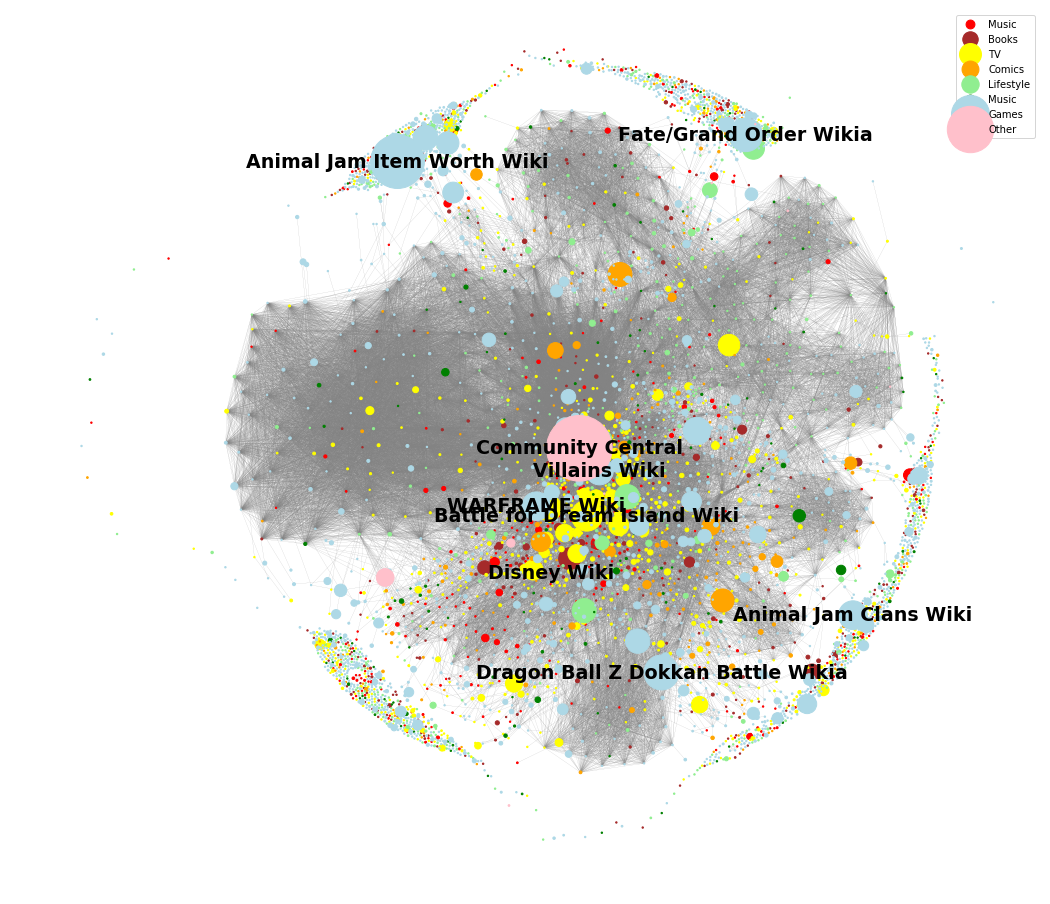

In [14]:
# plot figure
plt.figure(figsize=(18, 16))  


labels = {}    
for node in G.nodes():
    if int(G.nodes[node]['activeUsers']) > 750:
        #set the node name as the key and the label as its value 
        labels[node] = node


node_label = [node for node in G.nodes() ]
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Movies'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='red', label='Music')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Books'], node_size=node_size_books,cmap=plt.get_cmap('jet'), node_color='brown', label='Books')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['TV'], node_size=node_size_tv,cmap=plt.get_cmap('jet'), node_color='yellow', label='TV')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Comics'], node_size=node_size_comics,cmap=plt.get_cmap('jet'), node_color='orange', label='Comics')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Lifestyle'], node_size=node_size_lifestyle,cmap=plt.get_cmap('jet'), node_color='lightgreen', label='Lifestyle')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Music'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='green', label='Music')
nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
nx.draw_networkx_labels(G, positions, labels=labels, font_size=19, font_color='k', font_weight='bold', alpha=2.0)
nx.draw_networkx_nodes(G , positions, nodelist=nodes['Games'], node_size=node_size_games,cmap=plt.get_cmap('jet'), node_color='lightblue', label='Games')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Other'], node_size=node_size_other,cmap=plt.get_cmap('jet'), node_color='pink', label='Other')


plt.legend(numpoints = 1)
#texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
#adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.savefig('graphs/wikiNetworkUsers.png')
plt.show()

In [57]:
# Node size according to degree
def nodeSizeDegree(nodeList):
    return [(G.degree(node, weight='weight')*2) for node in nodeList]


node_size_games = nodeSizeDegree(nodes['Games'])
node_size_movies = nodeSizeDegree(nodes['Movies']) 
node_size_books = nodeSizeDegree(nodes['Books'])
node_size_tv = nodeSizeDegree(nodes['TV'])
node_size_comics = nodeSizeDegree(nodes['Comics'])
node_size_lifestyle = nodeSizeDegree(nodes['Lifestyle'])
node_size_other = nodeSizeDegree(nodes['Other'])
node_size_music = nodeSizeDegree(nodes['Music'])

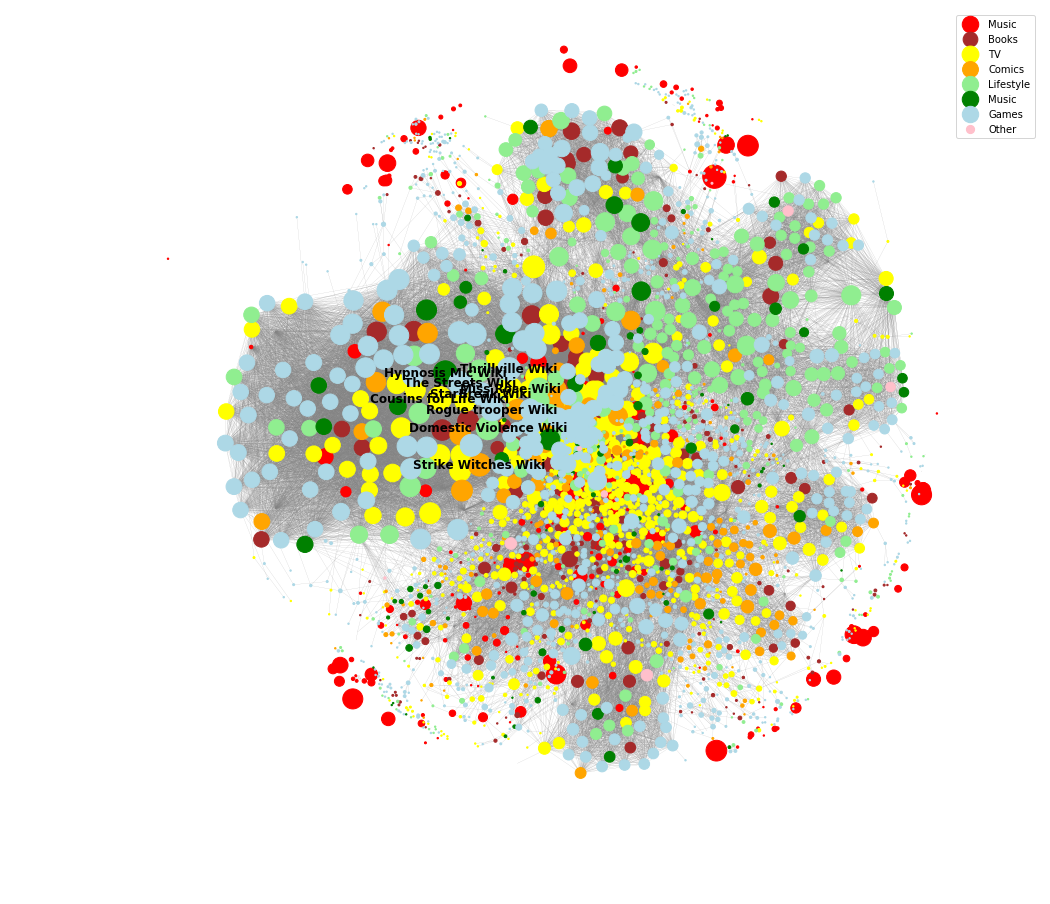

In [61]:
# plot figure
plt.figure(figsize=(18, 16))  

degrees = []
labels = {}    
for node in G.nodes():
    degrees.append(G.degree(node, weight='weight'))
    if G.degree(node, weight='weight')*2 > 500:
        #set the node name as the key and the label as its value 
        labels[node] = node


node_label = [node for node in G.nodes() ]
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Movies'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='red', label='Music')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Books'], node_size=node_size_books,cmap=plt.get_cmap('jet'), node_color='brown', label='Books')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['TV'], node_size=node_size_tv,cmap=plt.get_cmap('jet'), node_color='yellow', label='TV')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Comics'], node_size=node_size_comics,cmap=plt.get_cmap('jet'), node_color='orange', label='Comics')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Lifestyle'], node_size=node_size_lifestyle,cmap=plt.get_cmap('jet'), node_color='lightgreen', label='Lifestyle')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Music'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='green', label='Music')
nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
nx.draw_networkx_labels(G, positions, labels=labels, font_size=12, font_color='k', font_weight='bold', alpha=2.0)
nx.draw_networkx_nodes(G , positions, nodelist=nodes['Games'], node_size=node_size_games,cmap=plt.get_cmap('jet'), node_color='lightblue', label='Games')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Other'], node_size=node_size_other,cmap=plt.get_cmap('jet'), node_color='pink', label='Other')


plt.legend(numpoints = 1)
#texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
#adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.savefig('graphs/wikiNetworkDegree.png')
plt.show()

In [17]:
# Node size according to degree
def nodeSizeOccurances(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        usersOccurances = int(G.nodes[nodeList[i]]['usersOccurances'])*15  
        size.append(usersOccurances)
    print(max(size))
    return size


node_size_games = nodeSizeOccurances(nodes['Games'])
node_size_movies = nodeSizeOccurances(nodes['Movies']) 
node_size_books = nodeSizeOccurances(nodes['Books'])
node_size_tv = nodeSizeOccurances(nodes['TV'])
node_size_comics = nodeSizeOccurances(nodes['Comics'])
node_size_lifestyle = nodeSizeOccurances(nodes['Lifestyle'])
node_size_other = nodeSizeOccurances(nodes['Other'])
node_size_music = nodeSizeOccurances(nodes['Music'])

675
975
1020
645
300
315
135
540


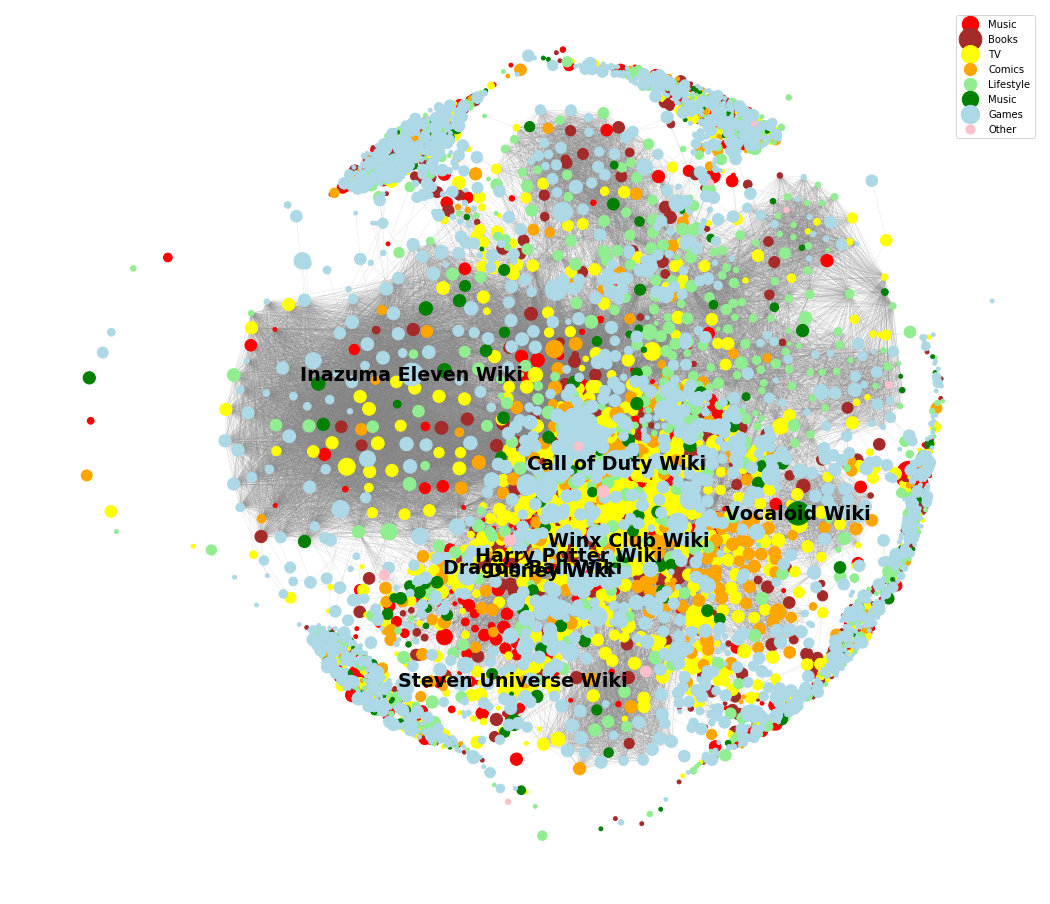

In [18]:
# plot figure
plt.figure(figsize=(18, 16))  

degrees = []
labels = {}    
for node in G.nodes():
    if int(G.nodes[node]['usersOccurances'])*15 > 500:
        #set the node name as the key and the label as its value 
        labels[node] = node


node_label = [node for node in G.nodes() ]
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Movies'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='red', label='Music')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Books'], node_size=node_size_books,cmap=plt.get_cmap('jet'), node_color='brown', label='Books')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['TV'], node_size=node_size_tv,cmap=plt.get_cmap('jet'), node_color='yellow', label='TV')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Comics'], node_size=node_size_comics,cmap=plt.get_cmap('jet'), node_color='orange', label='Comics')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Lifestyle'], node_size=node_size_lifestyle,cmap=plt.get_cmap('jet'), node_color='lightgreen', label='Lifestyle')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Music'], node_size=node_size_music,cmap=plt.get_cmap('jet'), node_color='green', label='Music')
nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
nx.draw_networkx_labels(G, positions, labels=labels, font_size=19, font_color='k', font_weight='bold', alpha=2.0)
nx.draw_networkx_nodes(G , positions, nodelist=nodes['Games'], node_size=node_size_games,cmap=plt.get_cmap('jet'), node_color='lightblue', label='Games')
nx.draw_networkx_nodes(G, positions, nodelist=nodes['Other'], node_size=node_size_other,cmap=plt.get_cmap('jet'), node_color='pink', label='Other')


plt.legend(numpoints = 1)
#texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
#adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.savefig('graphs/wikiNetworkUserOccurances.png')
plt.show()

In [31]:
len(G.edges())

45380

In [32]:
len(G.nodes())

5239

In [ ]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n)#, weight='weight')
    for hub in nodehubs:
        if hub not in hubsDegree:
            hubsDegree[hub] = []
        hubsDegree[hub].append(degree)
    if degree>maxDegree:
        maxDegree = degree

for k, degree in hubsDegree.items():
    print(k, max(degree))

In [ ]:
# Create Cumulative Step Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 30)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='step', 
         cumulative=True)
#patch.linewidth

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeCumulativeHist.png')
plt.show()

In [ ]:
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeHist.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree()]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeSumHist.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree() if val>1]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight with larger degree than 1")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreelarger1SumHist.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree() if val>2]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight with larger degree than 2")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreelarger2Hist.png')
plt.show()

In [ ]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n, weight='weight')
    for hub in nodehubs:
        if hub not in hubsDegree:
            hubsDegree[hub] = []
        hubsDegree[hub].append(degree)
    if degree>maxDegree:
        maxDegree = degree
    
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs with weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeWeightHist.png')
plt.show()

In [ ]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n, weight='weight')
    if degree > 2:
        for hub in nodehubs:
            if hub not in hubsDegree:
                hubsDegree[hub] = []
            hubsDegree[hub].append(degree)
        if degree>maxDegree:
            maxDegree = degree
    
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight and larger degree than 2")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreelarger2WeightHist.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree(weight='weight')]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution with weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeSumWeightHist.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree(weight='weight') if val>1]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution with weight and larger degree than 1")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
#plt.savefig('graphs/wikiDegreeSumlarger1WeightHist.png')
plt.show()

In [ ]:
# Data memory usage
sum(activeDataSet.memory_usage(index=False, deep=True))